# Data Exploration and Preprocessing

This notebook performs initial exploration of the sci-Plex dataset and preprocessing steps including quality control, normalization, and identification of highly variable genes.

## Dataset
- **Source:** sci-Plex (Srivatsan et al. 2020)
- **Cells:** 800K single cells from 3 cancer cell lines
- **Perturbations:** 188 drugs at multiple doses and timepoints

## Load Data


## 1. Load Raw Data

Load the complete sci-Plex dataset and inspect basic properties.

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.rcParams['figure.dpi'] = 80
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.dpi'] = 300

# Load data
adata = sc.read_h5ad('../data/raw/SrivatsanTrapnell2020_sciplex3.h5ad')

print(f"Dataset shape: {adata.shape}")
print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")




KeyboardInterrupt: 

## Explore Metadata

## 2. Explore Metadata

Examine the experimental metadata including cell lines, drug treatments, doses, and timepoints.

In [ ]:
# Explore metadata
print(" Available metadata columns:")
print(adata.obs.columns.tolist())

print("\n" + "="*50)
print("First few rows of metadata:")
print(adata.obs.head(10))

print("\n" + "="*50)
# Check what columns exist for treatments
if 'product_name' in adata.obs.columns:
    print(f"Number of unique drugs: {adata.obs['product_name'].nunique()}")
    print("\nTop 20 drugs by cell count:")
    print(adata.obs['product_name'].value_counts().head(20))
elif 'condition' in adata.obs.columns:
    print(f"Number of unique conditions: {adata.obs['condition'].nunique()}")
    print("\nTop 20 conditions by cell count:")
    print(adata.obs['condition'].value_counts().head(20))
elif 'perturbation' in adata.obs.columns:
    print(f"Number of unique perturbations: {adata.obs['perturbation'].nunique()}")
    print("\nTop 20 perturbations by cell count:")
    print(adata.obs['perturbation'].value_counts().head(20))
else:
    print("Column names available:")
    for col in adata.obs.columns:
        print(f"  - {col}")

print("\n" + "="*50)
# Check for cell line info
if 'cell_line' in adata.obs.columns:
    print(f"Cell lines: {adata.obs['cell_line'].unique()}")
    print("\nCells per cell line:")
    print(adata.obs['cell_line'].value_counts())
elif 'cell_type' in adata.obs.columns:
    print(f"Cell types: {adata.obs['cell_type'].value_counts()}")




 Available metadata columns:
['ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway_level_1', 'pathway_level_2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'cancer', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID']

First few rows of metadata:
                              ncounts        well    plate cell_line  \
cell_barcode                                                           
A01_E09_RT_BC_100_Lig_BC_147     2957   plate6_A9  plate44      MCF7   
A01_E09_RT_BC_100_Lig_BC_186     1528   plate8_H3  plate46      MCF7   
A01_E09_RT_BC_100_Lig_BC_196     1881   plate3_C2  plate41      MCF7   
A01_E09_RT_BC_100_Lig_BC_213     1700   plate9_E3  plate51      A549   
A01_E09_RT_BC_100_Lig_BC_220     1430  plate8_H10  plate30      K562   
A01_E09_RT_BC_100_Lig_BC_227      613   plate9_G9  plate47      MCF7   
A01_E09_RT_BC_100_Lig_BC_245     3094   plate9_C3  plat

## 3. Data Preprocessing

Filter to specific experimental conditions (dose=10000nM, time=24h) and perform quality control.

### Steps:
1. Remove cells with missing cell line information
2. Separate control vs treated cells
3. Filter to 24-hour timepoint
4. Quality control: Remove low-quality cells and genes
5. Normalize counts and log-transform
6. Identify highly variable genes

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np

# Load data
adata = sc.read_h5ad('../data/raw/SrivatsanTrapnell2020_sciplex3.h5ad')


print(f"Starting: {adata.n_obs} cells, {adata.n_vars} genes")

# ===== REMOVE NaN CELL LINES =====
adata = adata[~adata.obs['cell_line'].isna()].copy()
print(f"After removing NaN cell lines: {adata.n_obs} cells")

# ===== SEPARATE CONTROL VS TREATED FIRST =====
is_control = adata.obs['perturbation'] == 'control'
adata_control = adata[is_control].copy()
adata_treated = adata[~is_control].copy()

print(f"\nBefore filtering by time:")
print(f"Control cells: {adata_control.n_obs}")
print(f"Treated cells: {adata_treated.n_obs}")

# ===== FILTER BY TIME (24h for both control and treated) =====
# Control: dose_value = 0.0, time = 24.0
adata_control = adata_control[adata_control.obs['time'] == 24.0].copy()

# Treated: dose_value = 10000, time = 24.0
adata_treated = adata_treated[
    (adata_treated.obs['dose_value'] == 10000) & 
    (adata_treated.obs['time'] == 24.0)
].copy()

print(f"\nAfter filtering to time=24h:")
print(f"Control cells (dose=0): {adata_control.n_obs}")
print(f"Treated cells (dose=10000): {adata_treated.n_obs}")
print(f"Unique drugs in treated: {adata_treated.obs['perturbation'].nunique()}")

# ===== BASIC QC =====
for name, data in [('Control', adata_control), ('Treated', adata_treated)]:
    print(f"\nQC for {name}:")
    print(f"  Before: {data.n_obs} cells, {data.n_vars} genes")
    
    sc.pp.filter_genes(data, min_cells=10)
    sc.pp.filter_cells(data, min_genes=200)
    sc.pp.filter_cells(data, max_genes=7000)
    
    print(f"  After: {data.n_obs} cells, {data.n_vars} genes")

# ===== NORMALIZE DATA =====
for name, data in [('Control', adata_control), ('Treated', adata_treated)]:
    print(f"\nNormalizing {name}...")
    
    # Store raw counts
    data.layers["counts"] = data.X.copy()
    
    # Normalize
    sc.pp.normalize_total(data, target_sum=1e4)
    sc.pp.log1p(data)
    
    # Store normalized
    data.raw = data

print("\n✓ Normalization complete!")



Starting: 799317 cells, 110984 genes
After removing NaN cell lines: 762795 cells


In [ ]:
# ===== FIND HVGs =====
print("\nFinding HVGs...")
sc.pp.highly_variable_genes(adata_control, n_top_genes=3000, flavor='seurat_v3', layer='counts')
sc.pp.highly_variable_genes(adata_treated, n_top_genes=3000, flavor='seurat_v3', layer='counts')

print(f"HVGs in control: {adata_control.var['highly_variable'].sum()}")
print(f"HVGs in treated: {adata_treated.var['highly_variable'].sum()}")

# ===== SAVE =====
adata_control.write_h5ad('../data/processed/sciplex_control_dose0_24h.h5ad')
adata_treated.write_h5ad('../data/processed/sciplex_treated_dose10000_24h.h5ad')

print("\n✓ Preprocessing complete!")
print(f"Saved to: data/processed/")


Finding HVGs...
HVGs in control: 3000
HVGs in treated: 3000

✓ Preprocessing complete!
Saved to: data/processed/


## 4. Quality Control Visualization

Visual inspection of data quality after preprocessing.

Analyzing 15472 control cells
Number of genes: 22305


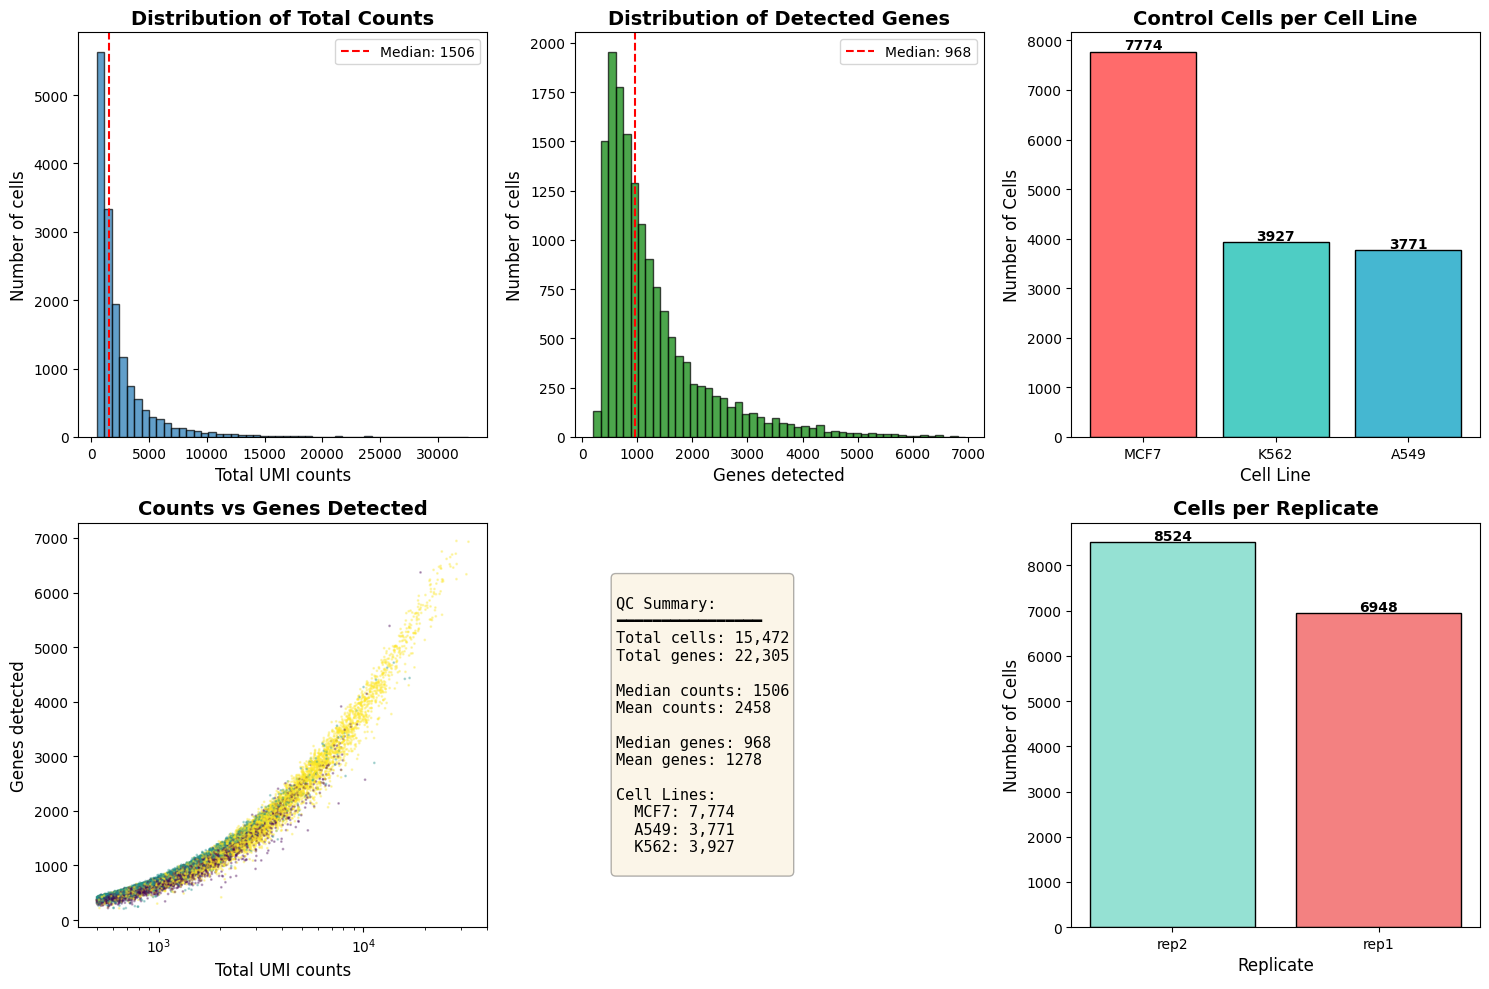


✓ QC plots saved to figures/01_control_qc_overview.png


In [ ]:
# Cell 3: QC Plots on Preprocessed Control Data
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your preprocessed CONTROL data
adata = sc.read_h5ad('../data/processed/sciplex_control_dose0_24h.h5ad')

print(f"Analyzing {adata.n_obs} control cells")
print(f"Number of genes: {adata.n_vars}")

# Calculate QC metrics if not already done
if 'total_counts' not in adata.obs.columns:
    sc.pp.calculate_qc_metrics(adata, layer='counts', inplace=True)

# ===== PLOT QC METRICS =====
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Total counts per cell
axes[0, 0].hist(adata.obs['ncounts'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Total UMI counts', fontsize=12)
axes[0, 0].set_ylabel('Number of cells', fontsize=12)
axes[0, 0].set_title('Distribution of Total Counts', fontsize=14, fontweight='bold')
axes[0, 0].axvline(adata.obs['ncounts'].median(), color='red', linestyle='--', 
                   label=f'Median: {adata.obs["ncounts"].median():.0f}')
axes[0, 0].legend()

# 2. Number of genes per cell
axes[0, 1].hist(adata.obs['ngenes'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Genes detected', fontsize=12)
axes[0, 1].set_ylabel('Number of cells', fontsize=12)
axes[0, 1].set_title('Distribution of Detected Genes', fontsize=14, fontweight='bold')
axes[0, 1].axvline(adata.obs['ngenes'].median(), color='red', linestyle='--',
                   label=f'Median: {adata.obs["ngenes"].median():.0f}')
axes[0, 1].legend()

# 3. Cell line distribution
cell_line_counts = adata.obs['cell_line'].value_counts()
axes[0, 2].bar(cell_line_counts.index, cell_line_counts.values, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1'], edgecolor='black')
axes[0, 2].set_xlabel('Cell Line', fontsize=12)
axes[0, 2].set_ylabel('Number of Cells', fontsize=12)
axes[0, 2].set_title('Control Cells per Cell Line', fontsize=14, fontweight='bold')
for i, v in enumerate(cell_line_counts.values):
    axes[0, 2].text(i, v + 50, str(v), ha='center', fontweight='bold')

# 4. Counts vs Genes scatter
axes[1, 0].scatter(adata.obs['ncounts'], adata.obs['ngenes'], 
                   alpha=0.3, s=1, c=adata.obs['cell_line'].astype('category').cat.codes, 
                   cmap='viridis')
axes[1, 0].set_xlabel('Total UMI counts', fontsize=12)
axes[1, 0].set_ylabel('Genes detected', fontsize=12)
axes[1, 0].set_title('Counts vs Genes Detected', fontsize=14, fontweight='bold')
axes[1, 0].set_xscale('log')

# 5. QC summary stats
summary_text = f"""
QC Summary:
━━━━━━━━━━━━━━━━
Total cells: {adata.n_obs:,}
Total genes: {adata.n_vars:,}

Median counts: {adata.obs['ncounts'].median():.0f}
Mean counts: {adata.obs['ncounts'].mean():.0f}

Median genes: {adata.obs['ngenes'].median():.0f}
Mean genes: {adata.obs['ngenes'].mean():.0f}

Cell Lines:
  MCF7: {(adata.obs['cell_line']=='MCF7').sum():,}
  A549: {(adata.obs['cell_line']=='A549').sum():,}
  K562: {(adata.obs['cell_line']=='K562').sum():,}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', 
                facecolor='wheat', alpha=0.3))
axes[1, 1].axis('off')

# 6. Replicate distribution
replicate_counts = adata.obs['replicate'].value_counts()
axes[1, 2].bar(replicate_counts.index, replicate_counts.values,
               color=['#95E1D3', '#F38181', '#AA96DA'], edgecolor='black')
axes[1, 2].set_xlabel('Replicate', fontsize=12)
axes[1, 2].set_ylabel('Number of Cells', fontsize=12)
axes[1, 2].set_title('Cells per Replicate', fontsize=14, fontweight='bold')
for i, v in enumerate(replicate_counts.values):
    axes[1, 2].text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../figures/01_control_qc_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ QC plots saved to figures/01_control_qc_overview.png")